### **Mục đích:**
1. Thống kê phân bố giá trị của mỗi trường dữ liệu.
2. Tổng hợp các phương pháp chuẩn hóa và làm sạch giữ liệu.
3. Làm giàu dữ liệu (enrich data).

#### **1. Thống kê phân bố giá trị của mỗi trường dữ liệu.**



### **2. Tổng hợp các phương pháp chuẩn hóa và làm sạch giữ liệu.**

*Dựa trên phân tích, thống kê đưa ra các phương pháp chuẩn hóa, làm sạch dữ liệu.*

#### **Type 1:** Dữ liệu không đồng nhất.

- Kiểu dữ liệu của trường chartdate trong các bảng đang không đồng nhất:
  + chartdate (bảng hcpcsevents) - date
  + chartdate (bảng microbiologyevents) - timestamp

  => Thông thường cần đồng nhất tất cả chartdate thành kiểu timestamp để tránh mất mát dữ liệu, tuy nhiên, tất cả giá trị trong trường chartdate (bảng microbiologyevents) đều có dạng 2193-01-05 00:00:00 (luôn luôn là 00:00:00), do đó, nên **đồng nhất tất cả chartdate thành kiểu date** (vừa không mất mát thông tin, vừa tránh dữ thừa dữ liệu vô nghĩa)

  => Trường storedate (bảng microbiologyevents) cũng vậy (giá trị ở dạng: YYYY/MM/DD 00:00:00) => Nên chuẩn hóa về định dạng date (YYYY/MM/DD) - bỏ đi phần 00:00:00 dư thừa.

- Quy đổi hết ICD-9 thành ICD-10 để dữ liệu đồng nhất, dễ xử lý.

- Ở **bảng microbiologyevents:**
  + **Cách biểu diễn kết quả âm tính (negative results):**

    + Thông thường, nếu xét nghiệm vi sinh không thấy vi khuẩn → kết quả sẽ để NULL.

    + Nhưng riêng với itemid = 90856, kết quả được ghi rõ là "NEGATIVE" (chữ NEGATIVE).

  => Chuẩn hóa về **NEGATIVE** hết cho nhất quán.

  + **hadm_id** đôi khi bị NULL, lý do là:
    + Trong thực tế:

      + Một số mẫu được lấy trước khi nhập viện chính thức (ví dụ: tại khoa cấp cứu trước khi hệ thống tạo admission record).

      + Một số xét nghiệm được thực hiện sau khi xuất viện (ví dụ: kết quả cấy vi sinh trả về muộn).

    + Trong các trường hợp này, hệ thống không tự gán **hadm_id**, vì về mặt hành chính xét nghiệm **không khớp chính xác với khoảng thời gian admittime → dischtime** =>  **Tìm cách gán chính xác hadm_id cho các bản ghi còn thiếu thông tin này.**

- Ở bảng **labevents:**
  + **labevents** hầu hết (98%) có thể gắn với một lần nhập viện (**hadm_id**). Nhưng một phần nhỏ bị thiếu **hadm_id** do:

    + Một kết quả xét nghiệm sẽ không có hadm_id nếu:

      + **Kết quả nằm ngoài một khoảng thời gian của bảng transfers**

          + transfers ghi nhận các lần bệnh nhân di chuyển trong viện (ED → ICU → Ward...).

          + Nếu xét nghiệm được làm trước khi hệ thống tạo record transfer, hoặc sau khi discharge thì sẽ “lọt” ra ngoài.

      + **Xét nghiệm không gắn với ED stay**

        + Một số bệnh nhân làm xét nghiệm ở khoa cấp cứu nhưng hệ thống không ghi nhận mã ED stay → không thể gắn vào một hospitalization chính thức.

  => **Dựa trên thông tin các bảng khác, cố gắng điền bù hadm_id cho các bản ghi còn thiếu giá trị này.**

#### **Type 2:** Xử lý dữ liệu Null, NaN, NONE, chuỗi rỗng,...

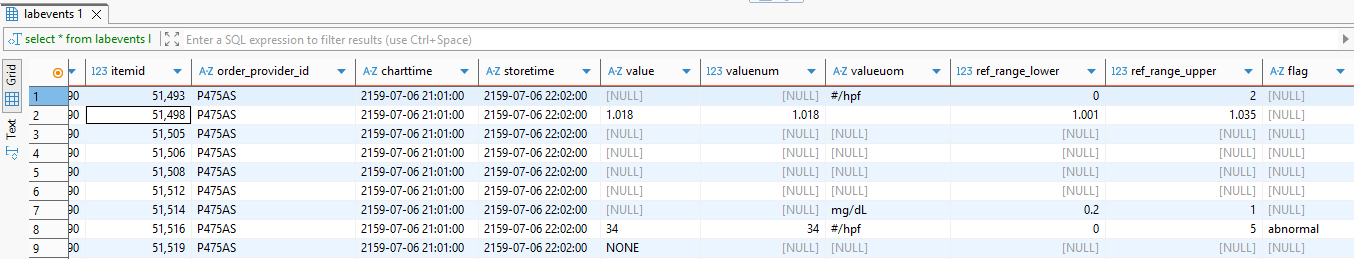

- Null "bình thường":

- Null "bất thường":

#### **Type 3:** Xử lý dữ liệu không logic.

##### 1. Bảng `chartevents`:

Dữ liệu hợp lệ về mặt kiểu (datatype) nhưng vô lý về mặt logic (business rule / domain knowledge). Ví dụ: Huyết áp giá trị âm, hoặc giá trị quá lớn thì phi lý. Hoặc tuổi mà âm hoặc lớn hơn 200 thì vô lý.

=> Giải pháp, thiết lập khoảng giá trị "hợp lý" cho mỗi loại phép đo (tham khảo dữ liệu khoa học khác để thiết lập khoảng).

**! Lưu ý:** Đối với các chỉ số y sinh (huyết áp, nhịp tim,...) thì khoảng giá trị "hợp lý" ở đây là khoảng giá trị thuộc **Phạm Vi Tổng Thể Hợp Lý Trong Giới Hạn Sinh Lý Của Con Người** (tức là không chỉ huyết áp lý tưởng, mà tính cả trong trường hợp đặc biệt như: dùng thuốc, phẫu thuật, hôn mê,...) miễn sao còn nằm trong phạm vi "còn sống".

#### **Type 4: Lỗi đánh máy.**

##### 1. Bảng `admission`:

- **deathtime** chỉ xuất hiện nếu bệnh nhân chết trong bệnh viện và hầu như luôn giống với **dischtime** của bệnh nhân. Tuy nhiên, có thể có một số khác biệt do lỗi đánh máy => Nếu **deathtime** tồn tại, thì phải chuẩn hóa nó = với **dischtime**.

#### **Type 5: Tạo surrogate key cho một số bảng đặc biệt.**

Các bảng cần tạo thêm surrogate key: poe_detail,

### **3. Làm giàu dữ liệu.**

- Thêm 1 trường về các ngưỡng "tồn tại" cho bảng d_item where linkto chartevents

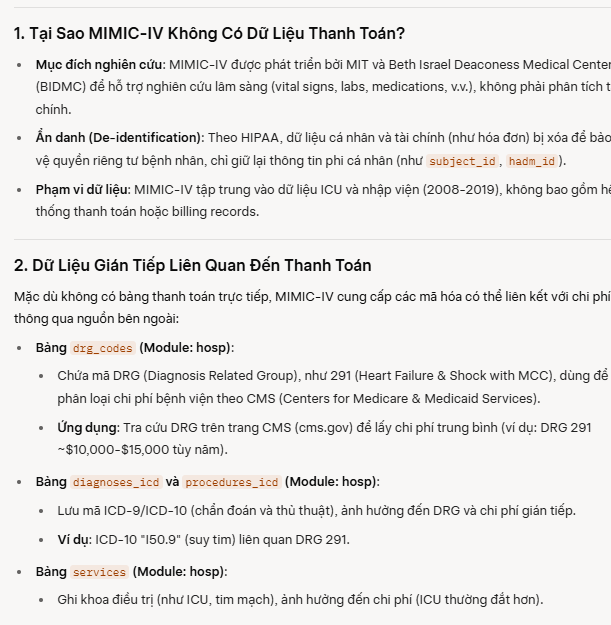

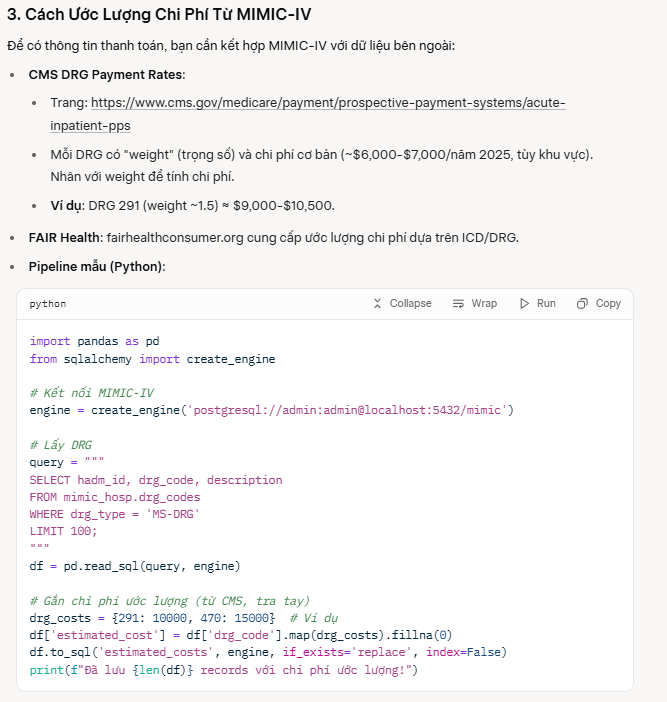

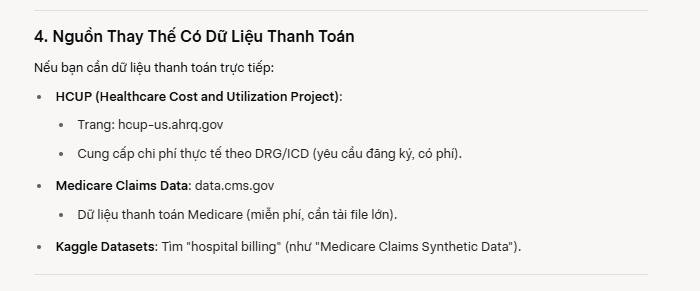